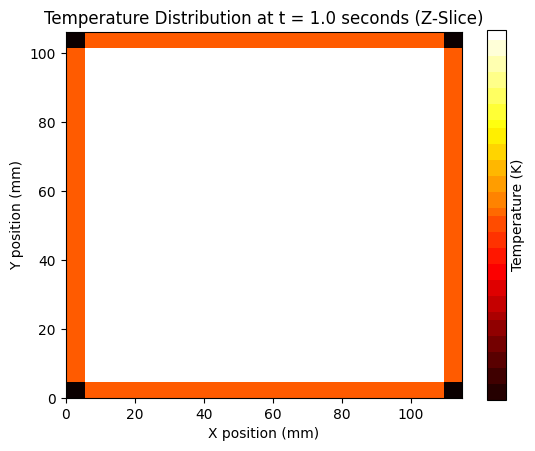

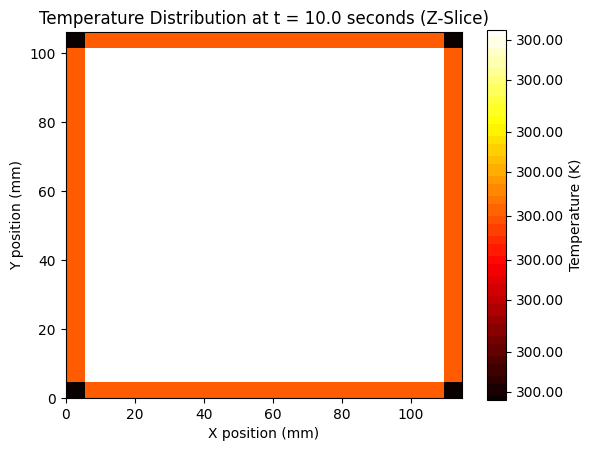

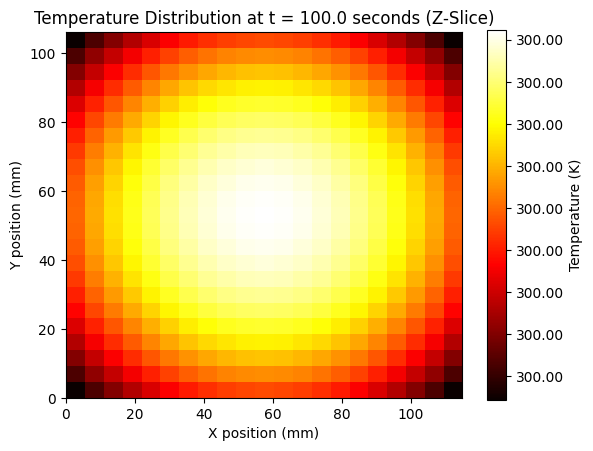

KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker


# Problem domain
# xyz is different from the datasheet
Lx = 115e-3  # Length along x (115 mm)
Ly = 106e-3  # Length along y (106 mm)
Lz = 22e-3   # Length along z (22 mm)
n_cells_x = 23  # Number of cells along x (46 cells)
n_cells_y = 21  # Number of cells along y (42 cells)
n_cells_z = 4   # Number of cells along z (8 cells)

dx = Lx / n_cells_x  # Grid spacing in x direction (meters)
dy = Ly / n_cells_y  # Grid spacing in y direction (meters)
dz = Lz / n_cells_z  # Grid spacing in z direction (meters)

kx = 36  # Thermal conductivity in the x direction (W/mK)
ky = 36  # Thermal conductivity in the y direction (W/mK)
kz = 1.3  # Thermal conductivity in the z direction (W/mK)

q_gen = 0.65  # Heat generation in W for the center point source
h = 4  # Convective heat transfer coefficient (W/m²K)
T_inf = 300  # Ambient temperature (K)

# Material properties
rho = 2032  # Density in kg/m^3
cp = 1200  # Specific heat capacity in J/kgK

# Initial temperature
T_initial = 300  # Initial temperature in K

# Volume of a single cell (in m³)
cell_volume = dx * dy * dz  # m³

# Heat generation per unit volume (W/m³)
q_gen_per_volume = q_gen / (n_cells_x*n_cells_y*n_cells_z)

# Time parameters
time_steps = [1, 10, 100, 1000, 2200, 3600]  # Times at which to plot temperatures
dt = 0.01  # Time step in seconds
num_time_steps = int(360 / dt)  # Total number of time steps (for up to 3650 seconds)

# Initialize temperature array (initial condition)
T = np.ones((n_cells_x, n_cells_y, n_cells_z)) * T_initial  # Set all cells to 300K initially
T_new = np.copy(T)

# Loop for time evolution
for step in range(num_time_steps):
    for i in range(n_cells_x):
        for j in range(n_cells_y):
            for k in range(n_cells_z):
                # Boundary conditions in x-direction
                if i == 0:  # Left boundary (x = 0)
                    T_new[i, j, k] = T[i+1, j, k] + (h * dx / kx) * (T_inf - T[i, j, k])                    

                elif i == n_cells_x - 1:  # Right boundary (x = Lx)
                    T_new[i, j, k] = T[i-1, j, k] + (h * dx / kx) * (T_inf - T[i, j, k])

                # Boundary conditions in y-direction
                elif j == 0:  # Bottom boundary (y = 0)
                    T_new[i, j, k] = T[i, j+1, k] + (h * dy / ky) * (T_inf - T[i, j, k])

                elif j == n_cells_y - 1:  # Top boundary (y = Ly)
                    T_new[i, j, k] = T[i, j-1, k] + (h * dy / ky) * (T_inf - T[i, j, k])

                # Boundary conditions in z-direction
                elif k == 0:  # Front boundary (z = 0)
                    T_new[i, j, k] = T[i, j, k+1] + (h * dz / kz) * (T_inf - T[i, j, k])

                elif k == n_cells_z - 1:  # Back boundary (z = Lz)
                    T_new[i, j, k] = T[i, j, k-1] + (h * dz / kz) * (T_inf - T[i, j, k])

                else:
                    # Internal cells
                    d2Tdx2 = (T[i+1, j, k] - 2 * T[i, j, k] + T[i-1, j, k]) / dx**2
                    d2Tdy2 = (T[i, j+1, k] - 2 * T[i, j, k] + T[i, j-1, k]) / dy**2
                    d2Tdz2 = (T[i, j, k+1] - 2 * T[i, j, k] + T[i, j, k-1]) / dz**2
                    heat_term = q_gen_per_volume / (rho * cp)

                    # Heat source in the center cell
                    # if i == n_cells_x // 2 and j == n_cells_y // 2 and k == n_cells_z // 2:
                    T_new[i, j, k] += dt * ((kx * d2Tdx2 + ky * d2Tdy2 + kz * d2Tdz2) / (rho * cp) + heat_term)
                    # else:
                    #     # Temperature update for non-source cells
                    #     T_new[i, j, k] += dt * ((kx * d2Tdx2 + ky * d2Tdy2 + kz * d2Tdz2) / (rho * cp))

    # Temperature field update for the next time step
    T = np.copy(T_new)

    # Plot temperature at specified times. Slice is through the centre of z.
    current_time = step * dt
    if np.isclose(current_time, 1) or np.isclose(current_time, 10) or np.isclose(current_time, 100) or \
       np.isclose(current_time, 1000) or np.isclose(current_time, 2200) or np.isclose(current_time, 3600):
        plt.imshow(T[:, :, n_cells_z // 2], origin='lower', extent=[0, Lx*1000, 0, Ly*1000], cmap='hot', interpolation='nearest')
        cbar = plt.colorbar(label='Temperature (K)')
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))  # Format colorbar to 2 decimal places
        plt.title(f'Temperature Distribution at t = {current_time:.1f} seconds (Z-Slice)')
        plt.xlabel('X position (mm)')
        plt.ylabel('Y position (mm)')
        plt.show()

# Final temp at the centre cell
center_temp = T[n_cells_x // 2, n_cells_y // 2, n_cells_z // 2]
print(f'Steady-state temperature at the center after 3650 seconds: {center_temp:.2f} K')
